In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import json

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth', 999)

In [3]:
def load_yaml(path):
    with open(path, 'r') as f:
        return yaml.safe_load(f)
def load_json(path):
    with open(path, 'r') as f:
        return json.load(f)

In [4]:
model_path = '../models/'

In [5]:
config_list = []
metric_list = []

for f in os.listdir(model_path):
    subdir = model_path + f + '/'
    config_path = subdir + 'config.yaml'
    metrics_path = subdir + 'metrics.json'
    if not (os.path.exists(config_path) and os.path.exists(metrics_path)):
        continue
    config_list.append(load_yaml(config_path))
    metric_list.append(load_json(metrics_path))

In [6]:
len(config_list), len(metric_list)

(8, 8)

In [7]:
def expand_config_item(config_item):
    expanded = {}
    expanded['input_padding'] = config_item['data']['input_padding']
    expanded['train_batch_size'] = config_item['loader']['train']['batch_size']
    expanded['n_beams'] = config_item['metrics']['n_beams']
    for k, v in config_item['model_args'].items():
        expanded[k] = v
    expanded['optimizer'] = config_item['optimizer']['type']
    for k, v in config_item['optimizer']['opt_args'].items():
        expanded[k] = v
#     handle all model args
#     handle all opt args
    expanded['n_warmup_steps'] = config_item['scheduler']['n_warmup_steps']
    expanded['nb_epochs'] = config_item['scheduler']['nb_epochs']
    return expanded

In [8]:
config_list = [expand_config_item(c) for c in config_list]
config_df = pd.DataFrame.from_dict(config_list)
drop_cols = []
for c in list(config_df):
    if config_df[c].nunique()==1:
        drop_cols.append(c)
config_df.drop(drop_cols, axis=1, inplace=True)

In [9]:
def get_nice_metrics(metric_list):
    correct = pd.DataFrame.from_dict([l['correct'] for l in metric_list])
    beam = pd.DataFrame.from_dict([{
        'beam_0_product' : l['beam_accuracy']['correct_product']['0'],
        'beam_0_factorization' : l['beam_accuracy']['correct_factorization']['0'],
        'beam_1_product' : l['beam_accuracy']['correct_product']['1'],
        'beam_1_factorization' : l['beam_accuracy']['correct_factorization']['1']
    } for l in metric_list])
    
    return [correct, beam]

In [11]:
merged = pd.concat([config_df] + get_nice_metrics(metric_list), axis=1)

In [74]:
merged

,input_padding,dim_feedforward,embed_dim,num_decoder_layers,num_encoder_layers,shared_embeddings,n_warmup_steps,nb_epochs,correct_product,correct_factorization,beam_0_product,beam_0_factorization,beam_1_product,beam_1_factorization,other_str
0,pad,512,128,6,6,True,4000,200,0.996927,0.303065,0.989706,0.222709,0.277022,0.080356,6_6_512_128_True_4000_200
1,pad,256,128,6,6,True,4000,200,0.997926,0.303833,0.992241,0.226089,0.277483,0.077744,6_6_256_128_True_4000_200
2,pad,256,128,6,6,True,2000,50,1.000000,0.286625,0.999923,0.215718,0.286164,0.070907,6_6_256_128_True_2000_50
3,pad,128,64,6,6,True,2000,50,0.999923,0.283706,0.999846,0.215718,0.272797,0.067988,6_6_128_64_True_2000_50
4,pad,128,64,10,10,True,2000,50,0.471845,0.136821,0.247062,0.060690,0.330030,0.076131,10_10_128_64_True_2000_50
5,pad,128,64,6,6,False,2000,50,0.999923,0.280633,0.999770,0.215487,0.262887,0.065146,6_6_128_64_False_2000_50
6,zeros,128,64,6,6,True,2000,50,0.999770,0.279097,0.999616,0.215564,0.257740,0.063532,6_6_128_64_True_2000_50
7,zeros,128,64,6,6,False,2000,50,0.999846,0.277406,0.999616,0.215487,0.254590,0.061919,6_6_128_64_False_2000_50


In [97]:
def plot_different_values(df, col):
    config_cols = ['num_encoder_layers', 'num_decoder_layers', 'input_padding', 'dim_feedforward', 'embed_dim', 'shared_embeddings', 'n_warmup_steps', 'nb_epochs']
    metric_cols = [c for c in list(df) if not c in config_cols]
    non_targets = [c for c in config_cols if not c==col]
    df['other_str'] = df[non_targets].apply(lambda x: '_'.join([str(x[i]) for i in range(len(x))]), axis=1)

    display(df)
    filtered = df.groupby('other_str').filter(lambda x: len(x) > 1)
    
    fig, ax = plt.subplots(nrows=2, ncols=2)
    ax[0,0].set_title('correct_product')
    ax[0,1].set_title('correct_factorization')
    ax[1,0].set_title('beam_0_product')
    ax[1,1].set_title('beam_0_factorization')
    
    n_levels = filtered[col].nunique()
    label_mapper = {label:i for i, label in enumerate(df[col].unique())}
    label_mapper_inv = {i : label for label, i in label_mapper.items()}
    print(label_mapper, label_mapper_inv)
    filtered['value'] = filtered[col].apply(lambda x: label_mapper[x])
    filtered.set_index(col, inplace=True)
    
    display(filtered)
    
    for title, group in filtered.groupby('other_str'):
        group['correct_product'].plot(ax=ax[0,0], label=title)
        group['correct_factorization'].plot(ax=ax[0,1], label=title)
        group['beam_0_product'].plot(ax=ax[1,0], label=title)
        group['beam_0_factorization'].plot(ax=ax[1,1], label=title)
        
        
        for i in range(ax.shape[0]):
            for j in range(ax.shape[1]):
                ax[i,j].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
                ax[i,j].set_xticks(np.arange(n_levels))
                ax[i,j].set_xticklabels([label_mapper_inv[i] for i in range(n_levels)])
    fig.set_size_inches(14,8)
    fig.tight_layout()
    plt.show()

# Input Type: Padding vs Zeros
* Bascially the same performance for all cases. But pad always won.
* So For future experiments, going to use pad instead of zeros

,input_padding,dim_feedforward,embed_dim,num_decoder_layers,num_encoder_layers,shared_embeddings,n_warmup_steps,nb_epochs,correct_product,correct_factorization,beam_0_product,beam_0_factorization,beam_1_product,beam_1_factorization,other_str
0,pad,512,128,6,6,True,4000,200,0.996927,0.303065,0.989706,0.222709,0.277022,0.080356,6_6_pad_512_128_True_4000
1,pad,256,128,6,6,True,4000,200,0.997926,0.303833,0.992241,0.226089,0.277483,0.077744,6_6_pad_256_128_True_4000
2,pad,256,128,6,6,True,2000,50,1.000000,0.286625,0.999923,0.215718,0.286164,0.070907,6_6_pad_256_128_True_2000
3,pad,128,64,6,6,True,2000,50,0.999923,0.283706,0.999846,0.215718,0.272797,0.067988,6_6_pad_128_64_True_2000
4,pad,128,64,10,10,True,2000,50,0.471845,0.136821,0.247062,0.060690,0.330030,0.076131,10_10_pad_128_64_True_2000
5,pad,128,64,6,6,False,2000,50,0.999923,0.280633,0.999770,0.215487,0.262887,0.065146,6_6_pad_128_64_False_2000
6,zeros,128,64,6,6,True,2000,50,0.999770,0.279097,0.999616,0.215564,0.257740,0.063532,6_6_zeros_128_64_True_2000
7,zeros,128,64,6,6,False,2000,50,0.999846,0.277406,0.999616,0.215487,0.254590,0.061919,6_6_zeros_128_64_False_2000


{200: 0, 50: 1} {0: 200, 1: 50}


,input_padding,dim_feedforward,embed_dim,num_decoder_layers,num_encoder_layers,shared_embeddings,n_warmup_steps,correct_product,correct_factorization,beam_0_product,beam_0_factorization,beam_1_product,beam_1_factorization,other_str,value
nb_epochs,,,,,,,,,,,,,,,


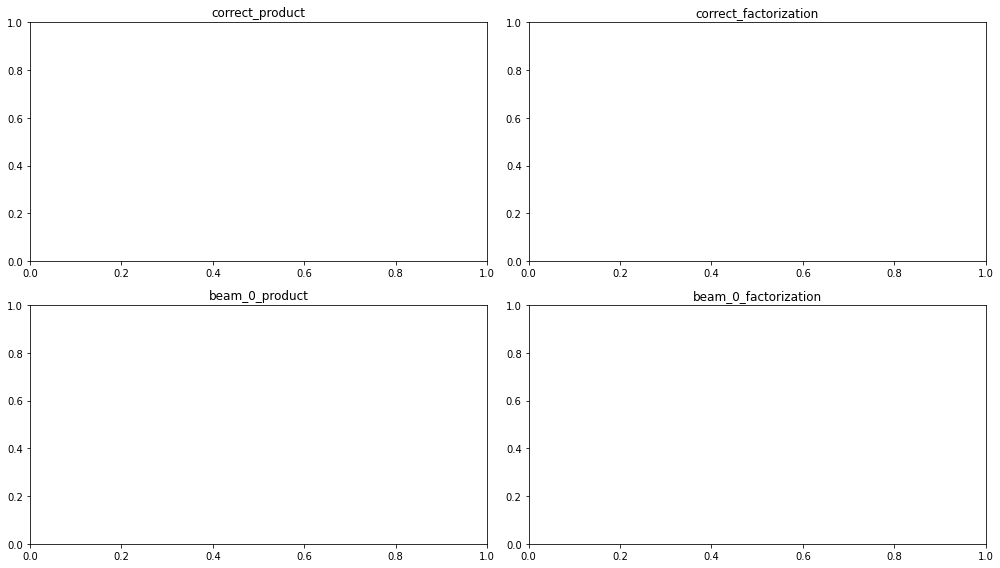

In [98]:
plot_different_values(merged, 'nb_epochs')

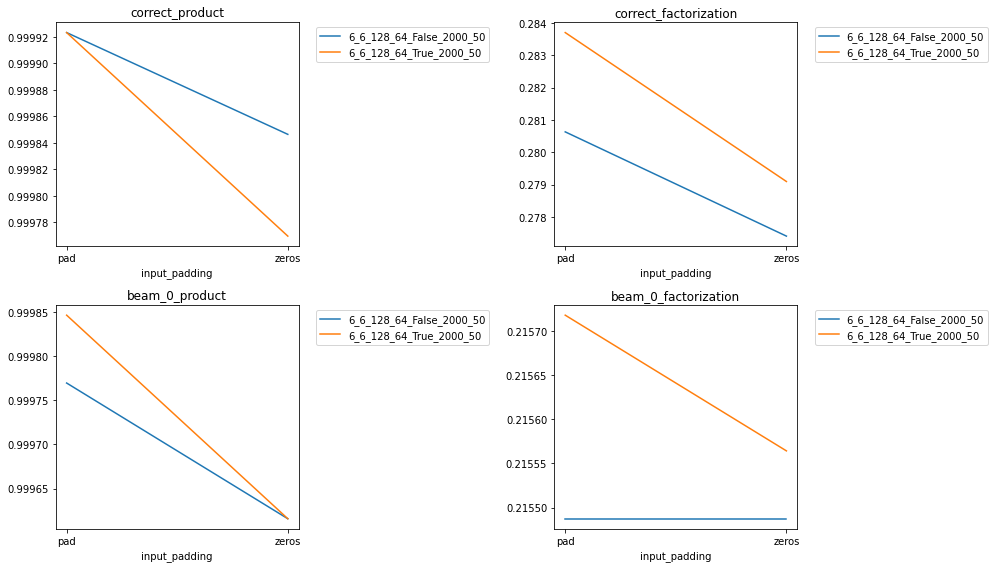

In [86]:
plot_different_values(merged, 'input_padding')